# EPS 261 Project

Walter Shen

In [1]:
import numpy as np
import pandas as pd
import datetime
from IPython.display import display 

# xarray
import xarray as xr

# plotting
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

### 1. Region of Interest

In [320]:
lon_range = [-15, 10]
lat_range = [45, 60]

# Dogger Bank
dog_lon = 2.7678
dog_lat = 54.7214

# Hook of Holland station location
hoh_lon = 4.12
hoh_lat = 51.9775

### 2. Present-day Topography from ETOPO01 Dataset

In [321]:
ds = xr.open_dataset('ETOPO1_Ice_c_gmt4.grd')
ds = ds.rename({'x': 'longitude', 'y': 'latitude'})
ds

<xarray.Dataset> Size: 2GB
Dimensions:    (longitude: 21600, latitude: 10800)
Coordinates:
  * longitude  (longitude) float64 173kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * latitude   (latitude) float64 86kB -89.99 -89.97 -89.96 ... 89.97 89.99
Data variables:
    z          (latitude, longitude) float64 2GB ...
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        ETOPO1_Ice_c_gmt4.grd
    GMT_version:  4.4.0
    node_offset:  1

In [322]:
ds_region = ds.sel(latitude=slice(lat_range[0], lat_range[1]), longitude=slice(lon_range[0], lon_range[1]))

ds_region

<xarray.Dataset> Size: 11MB
Dimensions:    (longitude: 1500, latitude: 900)
Coordinates:
  * longitude  (longitude) float64 12kB -14.99 -14.98 -14.96 ... 9.975 9.992
  * latitude   (latitude) float64 7kB 45.01 45.02 45.04 ... 59.96 59.97 59.99
Data variables:
    z          (latitude, longitude) float64 11MB ...
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        ETOPO1_Ice_c_gmt4.grd
    GMT_version:  4.4.0
    node_offset:  1

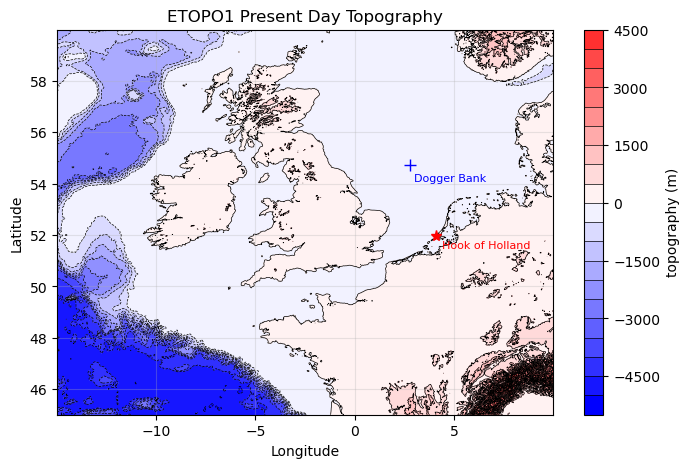

In [342]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
CS = ax.contourf(ds_region.longitude, ds_region.latitude, ds_region.z, 20, cmap='bwr', vmin=-np.max(np.abs(ds_region.z.values)), vmax=np.max(np.abs(ds_region.z.values)))
# add contour lines
CS2 = ax.contour(CS, levels=CS.levels[::1], colors='black', linewidths=0.5)
# colorbar
# cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical', pad=0.05)
# add contour lines to colorbar
cbar = fig.colorbar(CS, extend='min')
cbar.add_lines(CS2)
cbar.ax.set_ylabel('topography (m)')

# add a red star at Latitude 51.9775, Longitude 4.12 with label "Hook of Holland" 
ax.plot(hoh_lon, hoh_lat, 'r*', markersize=8)
ax.text(4.4, 51.4, 'Hook of Holland', fontsize=8, ha='left', va='bottom', color='red')

ax.plot(dog_lon, dog_lat, 'b+', markersize=8)
ax.text(3, 54, 'Dogger Bank', fontsize=8, ha='left', va='bottom', color='blue')

ax.set_title('ETOPO1 Present Day Topography')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(alpha = 0.3)
plt.savefig('topography_present.png', bbox_inches='tight')
plt.show()

### 3. Use global grids for the period 20ka to present day

In [293]:
# create our topography reconstruction file
Xkyr_topo = ds_region.copy()
Xkr = [1, 3, 5, 8, 10, 12, 14, 16, 18, 20]

In [299]:
for year in Xkr:
    print(year)
    # format as RSL_Xkyr.txt, X being Xkr year
    ice_age_filename = f'RSL_{year}kyr.txt'

    # read in the data
    ice_age = pd.read_csv(ice_age_filename, sep='\s+', header=None)

    # 257 rows are spaced evenly from the north pole (latitude 90 degrees N) to the south pole (latitude 90 degrees S).
    ice_lats = np.linspace(90, -90, 257)

    # 513 columns are spaced evenly from Greenwich (column 1 = 0 degrees longitude) and back to Greenwich (360 degrees longitude).
    ice_longs = np.linspace(0, 360, 513)
    # we want to knock out the last column since that's a duplicate of 0 degrees East
    ice_longs = ice_longs[:-1]
    ice_age = ice_age.drop(ice_age.columns[-1], axis=1)

    # transform coodinates
    ice_longs = np.where(ice_longs > 180, ice_longs - 360, ice_longs)

    sorted_indices = np.argsort(ice_longs)
    ice_longs_sorted = ice_longs[np.argsort(ice_longs)]
    ice_lats_sorted = ice_lats[np.argsort(ice_lats)]

    ice_age_sorted = ice_age.values[:, np.argsort(ice_longs)]
    ice_age_sorted = ice_age_sorted[np.argsort(ice_lats), :]

    ds_ice_age = xr.DataArray(
        data=ice_age_sorted,
        dims=['latitude', 'longitude'],
        coords={
            'latitude': ice_lats_sorted,
            'longitude':ice_longs_sorted
        },
        name='ice_age'
    )

    ds_ice_age_interp = ds_ice_age.interp_like(ds)

    ds_ice_age_region = ds_ice_age.sel(latitude=slice(lat_range[0], lat_range[1]), longitude=slice(lon_range[0], lon_range[1]))
    ds_ice_age_region_interp = ds_ice_age_interp.sel(latitude=slice(lat_range[0], lat_range[1]), longitude=slice(lon_range[0], lon_range[1]))

    Xkyr_topo[f'RSL_{year}'] = ds_ice_age_region_interp
    Xkyr_topo[f'topo_{year}'] = ds_region['z'] + ds_ice_age_region_interp.values

1
3
5
8
10
12
14
16
18
20


Text(0.5, 1.0, 'sea level change, 10 kya')

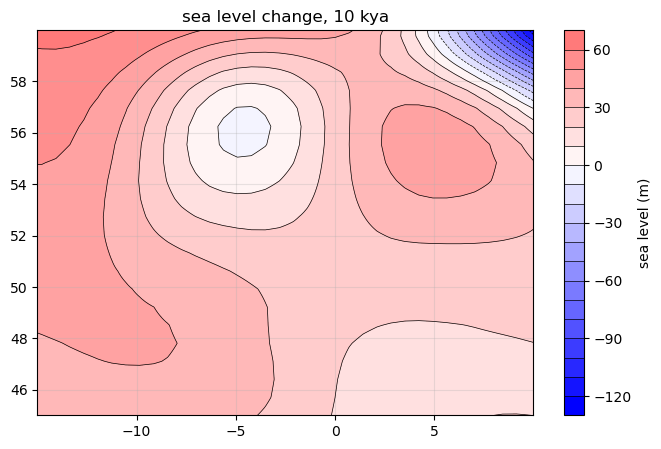

In [381]:
# Contour Plot
figs, ax = plt.subplots(1, 1, figsize=(8,5))
X, Y = np.meshgrid(ice_longs, ice_lats)

# Plot contours
CS = ax.contourf(Xkyr_topo.longitude, Xkyr_topo.latitude, Xkyr_topo.RSL_10, 20, cmap='bwr', vmin=-np.max(np.abs(Xkyr_topo.RSL_10.values)), vmax=np.max(np.abs(Xkyr_topo.RSL_10.values)))
# add contour lines
CS2 = ax.contour(CS, levels=CS.levels[::1], colors='black', linewidths=0.5)
# colorbar
# cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical', pad=0.05)
# add contour lines to colorbar


# plt.xlim(lon_range[0], lon_range[1])
# plt.ylim(lat_range[0], lat_range[1])

cbar = fig.colorbar(CS)
cbar.add_lines(CS2)
cbar.ax.set_ylabel('sea level (m)')
ax.grid(alpha = 0.3)

ax.set_title('sea level change, 10 kya')


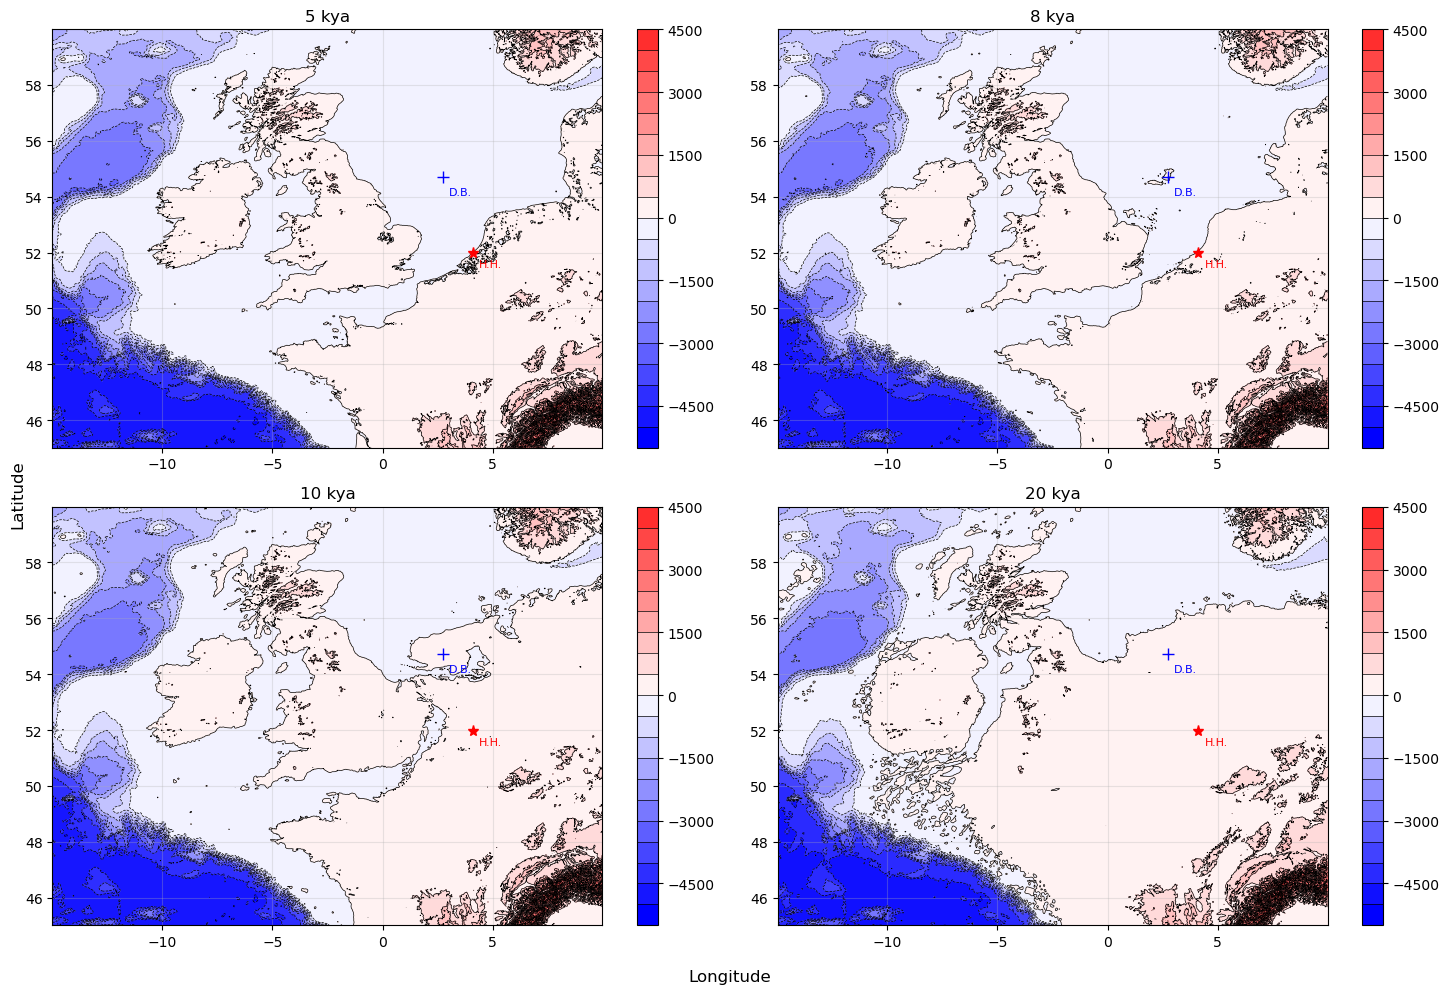

In [383]:
# Contour Plot; contour lines; colorbar
fig, axs = plt.subplots(2, 2, figsize=(15,10))
# X, Y = np.meshgrid(ice_longs, ice_lats)

CS = axs[0, 0].contourf(Xkyr_topo.longitude, Xkyr_topo.latitude, Xkyr_topo.topo_5, 20, cmap='bwr', vmin=-np.max(np.abs(Xkyr_topo.topo_5.values)), vmax=np.max(np.abs(Xkyr_topo.topo_5.values)))
CS2 = axs[0, 0].contour(CS, levels=CS.levels[::1], colors='black', linewidths=0.5)
axs[0, 0].plot(dog_lon, dog_lat, 'b+', markersize=8)
axs[0, 0].text(3, 54, 'D.B.', fontsize=8, ha='left', va='bottom', color='blue')
axs[0, 0].plot(hoh_lon, hoh_lat, 'r*', markersize=8)
axs[0, 0].text(4.4, 51.4, 'H.H.', fontsize=8, ha='left', va='bottom', color='red')
cbar = fig.colorbar(CS)
cbar.add_lines(CS2)
axs[0, 0].grid(alpha = 0.3)
axs[0, 0].set_title('5 kya')

CS = axs[0, 1].contourf(Xkyr_topo.longitude, Xkyr_topo.latitude, Xkyr_topo.topo_8, 20, cmap='bwr', vmin=-np.max(np.abs(Xkyr_topo.topo_8.values)), vmax=np.max(np.abs(Xkyr_topo.topo_8.values)))
CS2 = axs[0, 1].contour(CS, levels=CS.levels[::1], colors='black', linewidths=0.5)
axs[0, 1].plot(dog_lon, dog_lat, 'b+', markersize=8)
axs[0, 1].text(3, 54, 'D.B.', fontsize=8, ha='left', va='bottom', color='blue')
axs[0, 1].plot(hoh_lon, hoh_lat, 'r*', markersize=8)
axs[0, 1].text(4.4, 51.4, 'H.H.', fontsize=8, ha='left', va='bottom', color='red')
cbar = fig.colorbar(CS)
cbar.add_lines(CS2)
axs[0, 1].grid(alpha = 0.3)
axs[0, 1].set_title('8 kya')

CS = axs[1,0].contourf(Xkyr_topo.longitude, Xkyr_topo.latitude, Xkyr_topo.topo_10, 20, cmap='bwr', vmin=-np.max(np.abs(Xkyr_topo.topo_10.values)), vmax=np.max(np.abs(Xkyr_topo.topo_10.values)))
CS2 = axs[1,0].contour(CS, levels=CS.levels[::1], colors='black', linewidths=0.5)
axs[1,0].plot(dog_lon, dog_lat, 'b+', markersize=8)
axs[1,0].text(3, 54, 'D.B.', fontsize=8, ha='left', va='bottom', color='blue')
axs[1, 0].plot(hoh_lon, hoh_lat, 'r*', markersize=8)
axs[1, 0].text(4.4, 51.4, 'H.H.', fontsize=8, ha='left', va='bottom', color='red')
cbar = fig.colorbar(CS)
cbar.add_lines(CS2)
axs[1,0].grid(alpha = 0.3)
axs[1,0].set_title('10 kya')

CS = axs[1, 1].contourf(Xkyr_topo.longitude, Xkyr_topo.latitude, Xkyr_topo.topo_20, 20, cmap='bwr', vmin=-np.max(np.abs(Xkyr_topo.topo_20.values)), vmax=np.max(np.abs(Xkyr_topo.topo_20.values)))
CS2 = axs[1, 1].contour(CS, levels=CS.levels[::1], colors='black', linewidths=0.5)
axs[1, 1].plot(dog_lon, dog_lat, 'b+', markersize=8)
axs[1, 1].text(3, 54, 'D.B.', fontsize=8, ha='left', va='bottom', color='blue')
axs[1, 1].plot(hoh_lon, hoh_lat, 'r*', markersize=8)
axs[1, 1].text(4.4, 51.4, 'H.H.', fontsize=8, ha='left', va='bottom', color='red')
cbar = fig.colorbar(CS)
cbar.add_lines(CS2)
axs[1, 1].grid(alpha = 0.3)
axs[1, 1].set_title('20 kya')

fig.supxlabel('Longitude')
fig.supylabel('Latitude')
plt.tight_layout()

plt.savefig('topography_evol.png', bbox_inches='tight')

In [338]:
Xkyr_topo

<xarray.Dataset> Size: 248MB
Dimensions:    (longitude: 1500, latitude: 900)
Coordinates:
  * longitude  (longitude) float64 12kB -14.99 -14.98 -14.96 ... 9.975 9.992
  * latitude   (latitude) float64 7kB 45.01 45.02 45.04 ... 59.96 59.97 59.99
Data variables: (12/23)
    z          (latitude, longitude) float64 11MB -4.042e+03 ... 141.0
    RSL        (latitude, longitude) float64 11MB 135.2 135.2 ... -352.2 -353.0
    topo       (latitude, longitude) float64 11MB -3.907e+03 ... -212.0
    RSL_20     (latitude, longitude) float64 11MB 135.2 135.2 ... -352.2 -353.0
    topo_20    (latitude, longitude) float64 11MB -3.907e+03 ... -212.0
    RSL_1      (latitude, longitude) float64 11MB 0.4674 0.4677 ... -4.248
    ...         ...
    RSL_14     (latitude, longitude) float64 11MB 93.72 93.72 ... -270.0 -270.7
    topo_14    (latitude, longitude) float64 11MB -3.948e+03 ... -129.7
    RSL_16     (latitude, longitude) float64 11MB 124.9 124.9 ... -306.7 -307.5
    topo_16    (latitude, longitude) float64 11MB -3.917e+03 ... -166.5
    RSL_18     (latitude, longitude) float64 11MB 131.8 131.9 ... -331.0 -331.8
    topo_18    (latitude, longitude) float64 11MB -3.91e+03 -3.9e+03 ... -190.8
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        ETOPO1_Ice_c_gmt4.grd
    GMT_version:  4.4.0
    node_offset:  1

### Topography time series

In [402]:
time_series_kya = [0, 1, 3, 5, 8, 10, 12, 14, 16, 18, 20]

hoh_topo_time_series = [
    Xkyr_topo.z.sel(latitude=hoh_lat, longitude=hoh_lon, method ='nearest').values[()],
    Xkyr_topo.topo_1.sel(latitude=hoh_lat, longitude=hoh_lon, method ='nearest').values[()],
    Xkyr_topo.topo_3.sel(latitude=hoh_lat, longitude=hoh_lon, method ='nearest').values[()],
    Xkyr_topo.topo_5.sel(latitude=hoh_lat, longitude=hoh_lon, method ='nearest').values[()],
    Xkyr_topo.topo_8.sel(latitude=hoh_lat, longitude=hoh_lon, method ='nearest').values[()],
    Xkyr_topo.topo_10.sel(latitude=hoh_lat, longitude=hoh_lon, method ='nearest').values[()],
    Xkyr_topo.topo_12.sel(latitude=hoh_lat, longitude=hoh_lon, method ='nearest').values[()],
    Xkyr_topo.topo_14.sel(latitude=hoh_lat, longitude=hoh_lon, method ='nearest').values[()],
    Xkyr_topo.topo_16.sel(latitude=hoh_lat, longitude=hoh_lon, method ='nearest').values[()],
    Xkyr_topo.topo_18.sel(latitude=hoh_lat, longitude=hoh_lon, method ='nearest').values[()],
    Xkyr_topo.topo_20.sel(latitude=hoh_lat, longitude=hoh_lon, method ='nearest').values[()]
]

dog_topo_time_series = [
    Xkyr_topo.z.sel(latitude=dog_lat, longitude=dog_lon, method ='nearest').values[()],
    Xkyr_topo.topo_1.sel(latitude=dog_lat, longitude=dog_lon, method ='nearest').values[()],
    Xkyr_topo.topo_3.sel(latitude=dog_lat, longitude=dog_lon, method ='nearest').values[()],
    Xkyr_topo.topo_5.sel(latitude=dog_lat, longitude=dog_lon, method ='nearest').values[()],
    Xkyr_topo.topo_8.sel(latitude=dog_lat, longitude=dog_lon, method ='nearest').values[()],
    Xkyr_topo.topo_10.sel(latitude=dog_lat, longitude=dog_lon, method ='nearest').values[()],
    Xkyr_topo.topo_12.sel(latitude=dog_lat, longitude=dog_lon, method ='nearest').values[()],
    Xkyr_topo.topo_14.sel(latitude=dog_lat, longitude=dog_lon, method ='nearest').values[()],
    Xkyr_topo.topo_16.sel(latitude=dog_lat, longitude=dog_lon, method ='nearest').values[()],
    Xkyr_topo.topo_18.sel(latitude=dog_lat, longitude=dog_lon, method ='nearest').values[()],
    Xkyr_topo.topo_20.sel(latitude=dog_lat, longitude=dog_lon, method ='nearest').values[()]
]

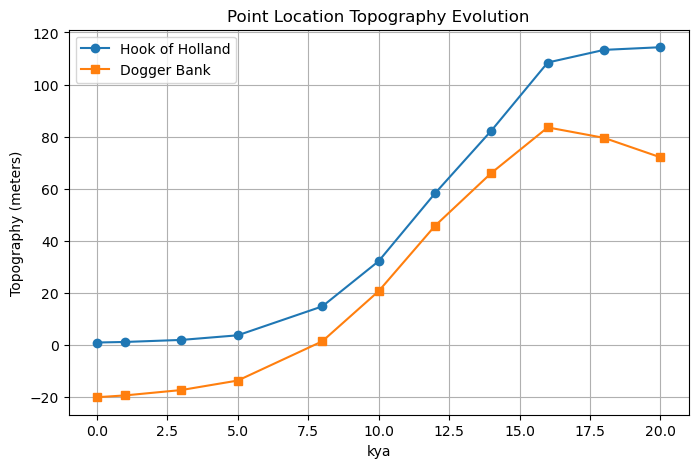

In [408]:
plt.figure(figsize=(8, 5))
plt.plot(time_series_kya, hoh_topo_time_series, label='Hook of Holland', marker='o')
plt.plot(time_series_kya, dog_topo_time_series, label='Dogger Bank', marker='s')

plt.xlabel('kya')
plt.ylabel('Topography (meters)')
plt.title('Point Location Topography Evolution')
plt.legend()
plt.grid(True)
plt.savefig('point_topo_evol.png', bbox_inches='tight')
plt.show()

### Coastline

In [277]:
# read in data

column_names = ['year', 'annual_data', 'xx', 'xy']
tide_data = pd.read_csv('22.rlrdata.txt', delimiter=';', names=column_names, header=0)
tide_data

,year,annual_data,xx,xy
0,1865,6553,N,0
1,1866,6605,N,0
2,1867,6598,N,0
3,1868,6607,N,0
4,1869,6644,N,0
...,...,...,...,...
154,2019,7011,N,0
155,2020,7009,N,0
156,2021,7001,N,0
157,2022,7008,N,0


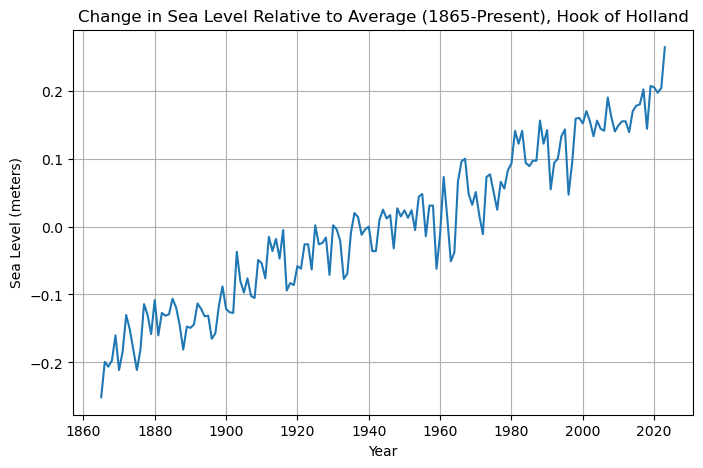

In [418]:
plt.figure(figsize=(8, 5))
plt.plot(tide_data['year'],(tide_data['annual_data']-np.mean(tide_data['annual_data']))/1000)

plt.xlabel('Year')
plt.ylabel('Sea Level (meters)')
plt.title('Change in Sea Level Relative to Average (1865-Present), Hook of Holland')
plt.grid(True)
plt.savefig('hoh_tide.png', bbox_inches='tight')
plt.show()